In the notebook `infermean_identify_highbias`, we tried to understand the cause of the positive bias in imputed mean temperatures.
We found that the imputations were particularly off on December 2nd at KBDL.
The true mean temperature on that day (17:00 UTC to to 17:00 UTC on December 2nd) was 3.375°C. 
The imputed mean temperature was 3.886°C ± 0.122: a >4σ error.

One hypothesis is that this is caused by the discrepancy between smoothmin and smoothmax, as on that the the temperatures stay low for a while.
We see a similar pattern (and magnitude of error) on June 2nd.

In [1]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [9]:
using Printf
using DataFrames
using JLD
using Dates
using GaussianProcesses: set_params!
import JSON
using Dates
using PDMats
using LinearAlgebra
using Statistics
using StatsBase: midpoints, Weights
using Distributions
using GaussianProcesses
using CmdStan
using Optim

GPmodel="matern"
ICAO="KBDL"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

5

In [3]:
using Revise
import TempModel

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/alternative_depots/climate/compiled/v1.1/TempModel/5V5SX.ji for TempModel [429a4ede-8e99-57b3-891e-c3971593d88c]
└ @ Base loading.jl:1184
┌ Warning: Package TempModel does not have LogDensityProblems in its dependencies:
│ - If you have TempModel checked out for development and have
│   added LogDensityProblems as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TempModel
└ Loading LogDensityProblems into TempModel from project dependency, future warnings for TempModel are suppressed.


In [4]:
module Batch
    using TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
#     include(joinpath(src_dir, "plot_map.jl"))
end

Main.Batch

In [5]:
# load kernel hyperparameters from JSON file
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

┌ Warning: dropmissing! will change eltype of cols to disallow missing by default. Use dropmissing!(df, cols, disallowmissing=false) to retain missing.
│   caller = dropmissing!(::DataFrame) at abstractdataframe.jl:733
└ @ DataFrames /Users/imolk/Library/Julia/alternative_depots/climate/packages/DataFrames/IKMvt/src/abstractdataframe/abstractdataframe.jl:733


In [6]:
hr_measure = Hour(17)
TnTx = TempModel.test_data(hourly_cat, itest, hr_measure)
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
# add column to test data for TnTx (useful for plotting)
hourly_test = join(hourly_test, TnTx, on=:ts_day)
;

# Optimizing posterior

In [7]:
test_fw = Batch.FittingWindow(Date(2015,10,20),Date(2016,1,1))
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir)
date_start = Date(2015,11,29)
impute_window = Day(7)
stan_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.01) # relaxed k, strict epsilon
;

In [29]:
L=LowerTriangular(stan_data["predicted_cov_chol"])

ksmoothmax = 10.0
epsilon = 0.01
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    L,
    stan_data["predicted_cov_chol"],
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
;

f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
@time opt_out = Optim.optimize(od, randn(pt.Nimpt); iterations=100000, f_tol=1e-14, x_tol=1e-12)

  1.555397 seconds (1.27 M allocations: 431.533 MiB, 8.72% gc time)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.18305455241823318,1.1764000677713113, ...]
 * Minimizer: [0.002376590653503162,0.01724164076774535, ...]
 * Minimum: 3.527135e+00
 * Iterations: 5573
 * Convergence: true
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 3.49e-08 
   * |f(x) - f(x')| ≤ 1.0e-14 |f(x)|: true
     |f(x) - f(x')| = 9.95e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.78e-04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 16419
 * Gradient Calls: 16419

In [30]:
q = Optim.minimizer(opt_out)
temp_impute = pt.μ + pt.chol*q;

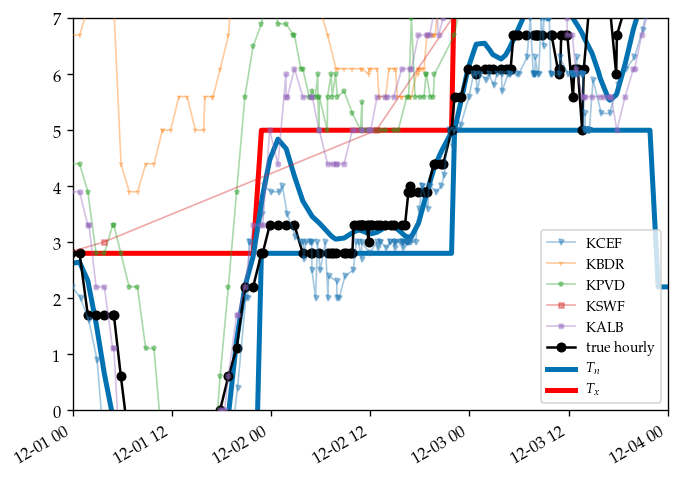

In [31]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=3)
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

Now steepen k:

In [48]:
ksmoothmax = 500.0
epsilon = 0.001
pt = TempModel.PredictTemperatures(
    stan_data["impt_times_p_day"],
    stan_data["Tn"],
    stan_data["Tx"],
    stan_data["predicted_mean"],
    L,
    stan_data["predicted_cov_chol"],
    stan_data["Nimpt"],
    stan_data["day_impute"],
    ksmoothmax, epsilon,
    stan_data["N_TxTn"],
    )
f = θ -> -TempModel.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -TempModel.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = TempModel.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
opt_out_steep = Optim.optimize(od, Optim.minimizer(opt_out); iterations=100000, f_tol=1e-16, x_tol=1e-12) 

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.002376590653503162,0.01724164076774535, ...]
 * Minimizer: [0.0024628776545338993,0.017057812964421958, ...]
 * Minimum: 3.124795e+00
 * Iterations: 18746
 * Convergence: false
   * |x - x'| ≤ 1.0e-12: false 
     |x - x'| = 2.58e-09 
   * |f(x) - f(x')| ≤ 1.0e-16 |f(x)|: false
     |f(x) - f(x')| = 1.42e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 8.36e-04 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 54334
 * Gradient Calls: 54334

In [49]:
q = Optim.minimizer(opt_out_steep)
temp_steep = pt.μ + pt.chol*q;

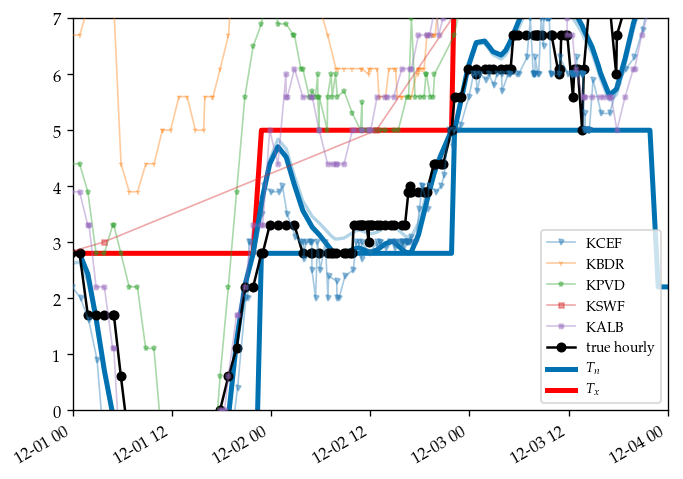

In [50]:
plt.plot(local_time.(ts_window), temp_impute, color=cbbPalette[5], linewidth=2, alpha=0.3)
plt.plot(local_time.(ts_window), temp_steep, color=cbbPalette[5], linewidth=3)
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

In [51]:
december2 = hourly_test[hourly_test[:ts_day] .== Date(2015,12,2), :]
true_mean_december2 = mean(december2[:temp])

3.375510204081634

In [58]:
impute_december2 = temp_impute[[t ∈ december2[:ts] for t in ts_window]]
mean(impute_december2) - mean(december2[:temp])

0.1376978566893743

In [60]:
impute_december2 = temp_steep[[t ∈ december2[:ts] for t in ts_window]]
mean(impute_december2) - mean(december2[:temp])

-0.08817437615103652

The error is -0.088°C. With the posterior standard deviation of 0.16, that's a 0.5σ error, much less than the posterior mean (3.2σ error at best).
Is it worth exploring initialising Stan at the optimum?